In [ ]:
import matplotlib, sys,  os
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
sys.path.append("./mylib/")

import numpy as np
matplotlib.use('Agg')
import matplotlib.pyplot as plt

from threeML import *
from WCDA_hal import HAL, HealpixConeROI, HealpixMapROI
import traceback
import warnings
# warnings.simplefilter("ignore")
silence_warnings()
from threeML import silence_progress_bars, activate_progress_bars, toggle_progress_bars
from threeML.utils.progress_bar import trange

from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
# from astropy.visualization import astropy_mpl_style, imshAow_norm
from astropy.coordinates import Angle

import healpy as hp

from tqdm import tqdm

# from mylib import *
import mylib as my
from importlib import reload

In [60]:
%matplotlib inline
#####   Data Initialize
# activate_warnings()

# maptree = "../../data/gcd_new.root"
# response="../../data/WCDA_DR_psf.root"

# maptree =  "../../data/hsc2healpix_20210305_20220930.root"
# response = "../../data/WCDA_DR2.root"

# maptree =  "../../data/20210305_20230731_ihep_no_goodlist.root"
# response = "../../data/DR_ihep_MK2.root"

# maptree =  "../../data/20210305_20230731_ihep_goodlist.root"
# response = "../../data/DR_ihep_MK2_newpsf.root"

maptree =  "../../data/20210305-20230731_trans_fromhsc.root"
response = "../../data/DR_ihep_MK2_newoldDRpsf.root"


region_name="Diffuse_WCDA_case14"
if not os.path.exists(f'../res/{region_name}/'):
    os.system(f'mkdir ../res/{region_name}/')


nside=2**10
npix=hp.nside2npix(nside)
pixarea = 4 * np.pi/npix
pixIdx = hp.nside2npix(nside) # number of pixels I can get from this nside
pixIdx = np.arange(pixIdx) # pixel index numbers
new_lats = hp.pix2ang(nside, pixIdx)[0] # thetas I need to populate with interpolated theta values
new_lons = hp.pix2ang(nside, pixIdx)[1] # phis, same
c_icrs = SkyCoord(ra=new_lons*180/np.pi*u.degree, dec=90*u.degree-new_lats*180/np.pi*u.degree, frame='icrs')
c_l=c_icrs.galactic.l.deg
c_b=c_icrs.galactic.b.deg

resultsall = []
for i,gl in enumerate(range(20,360,10)): # #!!!!!!!!!!!!!!!!!!!365   
    c_gal = SkyCoord(l=(gl)*u.degree, b=0*u.degree, frame='galactic')
    RA_center=c_gal.icrs.ra.deg
    Dec_center=c_gal.icrs.dec.deg
    if (Dec_center<-20. or Dec_center>80.): continue
    signal=np.zeros(npix,dtype=np.float64)
    mask = ( (c_l< gl + 5) & (c_l > gl - 5) & (c_b <5.) & (c_b>-5) & (90-new_lats/np.pi*180>-20) & (90-new_lats/np.pi*180<80)) #&(new_lats<110/180*np.pi )  & (new_lats > 10/180*np.pi )
        
    signal[mask]=1
    # hp.mollview(signal,title="ROI",norm='hist')
    # hp.graticule()
    ra1,dec1=RA_center, Dec_center

    data_radius = 7
    model_radius = 7.5

    roi = HealpixMapROI(ra=ra1,dec=dec1, data_radius=data_radius, model_radius=model_radius, roimap=signal)

    WCDA = HAL("WCDA", maptree, response, roi, flat_sky_pixels_size=0.17)

    #####   Data Situation
    %matplotlib inline
    WCDA.set_active_measurements(0, 5)
    WCDA.display()
    WCDA.psf_integration_method="exact"

    my.settransWCDA(WCDA, ra1, dec1)

    Modelname=f"roi_{gl - 5}-{gl + 5}"
    if not os.path.exists(f'../res/{region_name}/{Modelname}/'):
        os.system(f'mkdir ../res/{region_name}/{Modelname}/')
    fig = WCDA.display_stacked_image(smoothing_kernel_sigma=0.25)
    fig.savefig(f"../res/{region_name}/{Modelname}_counts_all.png",dpi=300)

    lm = my.getcatModel(ra1, dec1, data_radius, model_radius, rtsigma=8, rtflux=20, rtindex=10, rtp=8,  detector="WCDA", roi=roi, pf=False, sf=False, kf=False, indexf=False,  mkf=False, mindexf=False, setdeltabypar=True) #indexb=(-4,-1),

    Diffuse, diffscaleratio = my.set_diffusebkg(
                ra1, dec1, 8, 8, Kf=False, indexf=False, name=region_name, ifreturnratio=True, Kb=(1e-18, 1e-10), indexb=(-4.5, -0.5), index=-2.5, setdeltabypar=True
                ) #Kn=1 , K=1e-12
    
    lm.add_source(Diffuse)

    lm.save(f"../res/{region_name}/{Modelname}/Model_init.yml", overwrite=True)
    lm.display(complete=True)

    result = my.fit(region_name, Modelname, WCDA, lm, 0, 5, mini="ROOT", donwtlimit=True) # , ifgeterror=True
    sources = my.get_sources(lm,result)
    resultsall.append([result, sources, diffscaleratio])

    resu = my.getressimple(WCDA, lm)
    new_source_idx = np.where(resu==np.ma.max(resu))[0][0]
    new_source_lon_lat=hp.pix2ang(1024,new_source_idx,lonlat=True)
    print(new_source_lon_lat)

    plt.figure()
    hp.gnomview(resu,norm='',rot=[ra1,dec1],xsize=200,ysize=200,reso=6,title=Modelname)
    plt.scatter(new_source_lon_lat[0],new_source_lon_lat[1],marker='x',color='red')
    plt.show()
    plt.savefig(f"../res/{region_name}/{Modelname}_res.png",dpi=300)

    map2, skymapHeader = hp.read_map("../../data/fullsky_WCDA_llh-2.6.fits.gz",h=True)
    map2 = my.maskroi(map2, roi)
    sources.pop("Diffuse")
    fig = my.drawmap(region_name, Modelname, sources, map2, ra1, dec1, rad=2*data_radius, contours=[10000],save=1, 
                    color="Fermi",
                    colors = my.colorall
                    )
    # try:
    Flux_WCDA0, jls0  = my.getdatapoint(WCDA, lm, maptree, response, roi, "Diffuse", ifpowerlawM=1, iffixtans=1)
    import matplotlib as mpl

    x_Max=50.
    x_Min=1
    y_Min=0.8e-13
    y_Max=2e-10
    fig,ax = plt.subplots()
    plot_spectra(
        result[0].results,
        sources_to_use=["Diffuse"], #,"ext1","ext2","ext4","ext5","ext6","ext7"|
        include_extended=True,
        ene_min=x_Min,
        ene_max=x_Max,
        num_ene=30,
        energy_unit="TeV",
        flux_unit="TeV/(s cm2)",
        subplot=ax,
        )

    my.Draw_sepctrum_points(region_name, Modelname, Flux_WCDA0,"Diffuse","tab:red")

    ax.set_xlim(x_Min,x_Max)
    ax.set_ylim(y_Min,y_Max)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylabel(r"$E^2\,dN/dE$ [TeV cm$^{-2}$ s$^{-1}$]")
    ax.set_xlabel("Energy [TeV]")
    plt.legend()
    plt.savefig(f'../res/{region_name}/{Modelname}/Spectrum.png', dpi=300)
    plt.savefig(f'../res/{region_name}/{Modelname}/Spectrum.pdf')
    # except:   pass
    #     continue

Load sub from Myspeedup: 100%|██████████| 37/37 [00:13<00:00, 107.08it/s]

17:40:27 INFO      Region of Interest:                                                                   ]8;id=708049;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=864808;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#292\292]8;;\

         INFO      -------------------                                                                   ]8;id=731382;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=123447;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#293\293]8;;\

         INFO      HealpixMapROI: Center (R.A., Dec) = (276.882, -11.489), model radius:     ]8;id=913457;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/region_of_interest/healpix_map_roi.py\healpix_map_roi.py]8;;\:]8;id=709952;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/region_of_interest/healpix_map_roi.py#134\134]8;;\
                  7.500 deg, display radius: 7.000 deg, threshold = 0.50                                           

         INFO                                                                                            ]8;id=754239;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=461649;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#296\296]8;;\

         INFO      Flat sky projection:                                                                  ]8;id=89921;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=612582;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#297\297]8;;\

         INFO      --------------------                                                                  ]8;id=737921;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=776296;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#298\298]8;;\

         INFO      Width x height 90 x 90 px                                                             ]8;id=418839;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=42188;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#300\300]8;;\

         INFO      Pixel sizes: 0.17 deg                                                                 ]8;id=337685;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=473915;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#305\305]8;;\

         INFO                                                                                            ]8;id=132869;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=600487;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#308\308]8;;\

         INFO      Response:                                                                             ]8;id=516035;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=275445;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#309\309]8;;\

         INFO      ---------                                                                             ]8;id=266559;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=744251;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#310\310]8;;\

         INFO      Response file:                                                                   ]8;id=340380;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/response/response.py\response.py]8;;\:]8;id=931792;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/response/response.py#340\340]8;;\
                  /data/home/cwy/Science/3MLWCDA/Standard/src/../../data/DR_ihep_MK2_newoldDRpsf.ro                
                  ot                                                                                               

         INFO      Number of dec bins: 110                                                          ]8;id=847035;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/response/response.py\response.py]8;;\:]8;id=465483;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/response/response.py#341\341]8;;\

         INFO      Number of energy/nHit planes per dec bin_name: 6                                 ]8;id=216196;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/response/response.py\response.py]8;;\:]8;id=588400;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/response/response.py#344\344]8;;\

         INFO                                                                                            ]8;id=874503;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=535226;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#314\314]8;;\

         INFO      Map Tree:                                                                             ]8;id=696967;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=184397;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#315\315]8;;\

         INFO      ----------                                                                            ]8;id=113843;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=262296;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#316\316]8;;\

,Bin,Nside,Scheme,Obs counts,Bkg counts,obs/bkg,Pixels in ROI,Area (deg^2)
0,0,1024,RING,1.912300e+06,1.890370e+06,1.011601,30460,99.86283
1,1,1024,RING,1.068157e+06,1.046597e+06,1.020600,30460,99.86283
2,2,1024,RING,1.897779e+05,1.829351e+05,1.037405,30460,99.86283
3,3,1024,RING,7.547907e+04,7.138014e+04,1.057424,30460,99.86283
4,4,1024,RING,1.752258e+04,1.629416e+04,1.075390,30460,99.86283
5,5,1024,RING,5.342905e+03,4.608799e+03,1.159284,30460,99.86283


         INFO      This Map Tree contains 795.961 transits in the first bin                         ]8;id=575334;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/maptree/map_tree.py\map_tree.py]8;;\:]8;id=373865;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/maptree/map_tree.py#149\149]8;;\

         INFO      Total data size: 2.92 Mb                                                         ]8;id=235116;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/maptree/map_tree.py\map_tree.py]8;;\:]8;id=304455;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/maptree/map_tree.py#151\151]8;;\

         INFO                                                                                            ]8;id=543757;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=867301;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#320\320]8;;\

         INFO      Active energy/nHit planes (6):                                                        ]8;id=818531;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=113606;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#322\322]8;;\

         INFO      -------------------------------                                                       ]8;id=962772;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=100273;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#323\323]8;;\

         INFO      ['0', '1', '2', '3', '4', '5']                                                        ]8;id=764285;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=824309;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#324\324]8;;\

17:40:28 INFO      Set WCDA tansit from: 795.9613310185185 to 796.2928263888889                         ]8;id=342587;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Mymap.py\Mymap.py]8;;\:]8;id=120689;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Mymap.py#41\41]8;;\

17:40:29 INFO      J1813M1245 in roi: 7 sf:False pf:False kf:False indexf:False                        ]8;id=7355;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=591637;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#320\320]8;;\

         INFO      Spec:                                                                               ]8;id=878114;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=955108;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#348\348]8;;\
                   K=2.44e-13 kb=(2.44e-15, 1.12e-12) index=-2.61 indexb=(-3.41,-1.81)                             

         INFO      Mor: fitrange=1.68                                                                  ]8;id=441363;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=567461;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#358\358]8;;\

         INFO      J1814M1719u in model_radius: 7.5 sf:True pf:True kf:False indexf:False              ]8;id=897629;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=20451;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#327\327]8;;\

         INFO      Spec:                                                                               ]8;id=417617;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=862831;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#348\348]8;;\
                   K=2.65e-12 kb=(2.65e-14, 7.57e-12) index=-2.83 indexb=(-3.43,-2.23)                             

         INFO      Mor:                                                                                ]8;id=382006;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=855105;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#350\350]8;;\
                   sigma=0.71 sb=(0.15,1.27) fitrange=2.16                                                         

         INFO      J1825M1418 in roi: 7 sf:False pf:False kf:False indexf:False                        ]8;id=708056;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=684172;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#320\320]8;;\

         INFO      Spec:                                                                               ]8;id=146933;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=219650;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#348\348]8;;\
                   K=3.92e-12 kb=(3.92e-14, 8.52e-12) index=-2.98 indexb=(-3.48,-2.48)                             

         INFO      Mor:                                                                                ]8;id=458851;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=393359;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#350\350]8;;\
                   sigma=0.81 sb=(0.41,1.21) fitrange=1.52                                                         

         INFO      J1825M1256u in roi: 7 sf:False pf:False kf:False indexf:False                       ]8;id=858085;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=205000;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#320\320]8;;\

         INFO      Spec:                                                                               ]8;id=89028;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=602677;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#348\348]8;;\
                   K=8.27e-13 kb=(8.27e-15, 1.91e-12) index=-2.61 indexb=(-2.91,-2.31)                             

         INFO      Mor:                                                                                ]8;id=828497;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=622973;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#350\350]8;;\
                   sigma=0.24 sb=(0.00,0.48) fitrange=0.64                                                         

         INFO      J1825M1337u in roi: 7 sf:False pf:False kf:False indexf:False                       ]8;id=146171;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=696578;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#320\320]8;;\

         INFO      Spec:                                                                               ]8;id=780393;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=175543;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#348\348]8;;\
                   K=1.04e-12 kb=(1.04e-14, 2.16e-12) index=-2.55 indexb=(-2.85,-2.25)                             

         INFO      Mor:                                                                                ]8;id=302434;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=720851;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#350\350]8;;\
                   sigma=0.17 sb=(0.01,0.33) fitrange=0.40                                                         

         INFO      J1831M1007u in roi: 7 sf:False pf:False kf:False indexf:False                       ]8;id=377726;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=27543;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#320\320]8;;\

         INFO      Spec:                                                                               ]8;id=243151;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=804392;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#348\348]8;;\
                   K=1.78e-12 kb=(1.78e-14, 3.90e-12) index=-2.71 indexb=(-3.11,-2.31)                             

         INFO      Mor:                                                                                ]8;id=192388;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=131938;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#350\350]8;;\
                   sigma=0.78 sb=(0.46,1.10) fitrange=1.28                                                         

         INFO      J1834M0831 in roi: 7 sf:False pf:False kf:False indexf:False                        ]8;id=638011;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=524825;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#320\320]8;;\

         INFO      Spec:                                                                               ]8;id=286073;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=701413;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#348\348]8;;\
                   K=5.99e-13 kb=(5.99e-15, 2.78e-12) index=-3.08 indexb=(-4.00,-1.78)                             

         INFO      Mor:                                                                                ]8;id=164348;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=125829;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#350\350]8;;\
                   sigma=0.40 sb=(0.00,0.96) fitrange=1.76                                                         

         INFO      J1837M0654u in model_radius: 7.5 sf:True pf:True kf:False indexf:False              ]8;id=77910;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=116609;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#327\327]8;;\

         INFO      Spec:                                                                               ]8;id=122945;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=156034;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#348\348]8;;\
                   K=1.55e-12 kb=(1.55e-14, 2.63e-12) index=-2.92 indexb=(-3.22,-2.62)                             

         INFO      Mor:                                                                                ]8;id=247586;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=255956;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#350\350]8;;\
                   sigma=0.34 sb=(0.26,0.42) fitrange=0.48                                                         

         INFO      J1839M0548u in model_radius: 7.5 sf:True pf:True kf:False indexf:False              ]8;id=407870;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=800594;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#327\327]8;;\

         INFO      Spec:                                                                               ]8;id=177953;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=395091;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#348\348]8;;\
                   K=4.62e-13 kb=(4.62e-15, 1.04e-12) index=-2.65 indexb=(-3.05,-2.25)                             

         INFO      Mor:                                                                                ]8;id=313195;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=921145;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#350\350]8;;\
                   sigma=0.22 sb=(0.06,0.38) fitrange=0.56                                                         

         INFO      J1841M0519 in model_radius: 7.5 sf:True pf:True kf:False indexf:False               ]8;id=666713;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=634075;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#327\327]8;;\

         INFO      Spec:                                                                               ]8;id=540474;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=947078;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#348\348]8;;\
                   K=1.52e-12 kb=(1.52e-14, 3.20e-12) index=-2.88 indexb=(-3.28,-2.48)                             

         INFO      Mor:                                                                                ]8;id=939135;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=23329;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#350\350]8;;\
                   sigma=0.60 sb=(0.36,0.84) fitrange=0.72                                                         

         INFO      Set diffuse range: [11, 27] [-8, 8]                                                ]8;id=81542;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=71672;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#1163\1163]8;;\

         INFO      ra dec coner:                                                                      ]8;id=17977;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=742689;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#1164\1164]8;;\

         INFO      (280.0678675034105, -23.118891913051822)                                           ]8;id=702796;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=408414;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#1165\1165]8;;\

         INFO      (287.34086682842513, -8.890290164211233)                                           ]8;id=258806;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=819890;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#1166\1166]8;;\

         INFO      (273.03715951687303, -1.5828020256848583)                                          ]8;id=224332;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=187971;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#1167\1167]8;;\

         INFO      (265.1960440779179, -15.40968155547338)                                            ]8;id=820174;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=166795;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#1168\1168]8;;\

         INFO      total sr: 0.07772890321151499                                                      ]8;id=150403;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=48310;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#1207\1207]8;;\
                  ratio: 0.028307125215400412                                                                      

         INFO      integration: 1.1782021422056108e-05                                                ]8;id=683914;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=878337;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#1208\1208]8;;\
                  ratio: 0.09297849542461918                                                                       

         INFO      set K to: 1.6670658179191998e-12                                                   ]8;id=147225;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=718821;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#1209\1209]8;;\

         INFO      diffuse file path: ../../data/Diffuse_WCDA_case14_dust_bkg_template.fits           ]8;id=496971;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=168555;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#1236\1236]8;;\

Model summary:
==============

                   N
Point sources      1
Extended sources  10
Particle sources   0

Free parameters (39):
--------------------

                                           value min_value max_value   
J1813M1245.position.ra                    273.35    271.67    275.03  \
J1813M1245.position.dec                   -12.73    -14.41    -11.05   
J1813M1245.spectrum.main.Powerlaw.K          0.0       0.0       0.0   
J1813M1245.spectrum.main.Powerlaw.index    -2.61     -3.41     -1.81   
J1814M1719u.spectrum.main.Powerlaw.K         0.0       0.0       0.0   
J1814M1719u.spectrum.main.Powerlaw.index   -2.83     -3.43     -2.23   
J1825M1418.Gaussian_on_sphere.lon0        276.29    274.77    277.81   
J1825M1418.Gaussian_on_sphere.lat0        -14.32    -15.84     -12.8   
J1825M1418.Gaussian_on_sphere.sigma         0.81      0.41      1.21   
J1825M1418.spectrum.main.Powerlaw.K          0.0       0.0       0.0   
J1825M1418.spectrum.main.Powerlaw.index    -2.98     -3.48     -2.48   
J1825M1256u.Gaussian_on_sphere.lon0       276.55    275.91    277.19   
J1825M1256u.Gaussian_on_sphere.lat0       -13.04    -13.68     -12.4   
J1825M1256u.Gaussian_on_sphere.sigma        0.24       0.0      0.48   
J1825M1256u.spectrum.main.Powerlaw.K         0.0       0.0       0.0   
J1825M1256u.spectrum.main.Powerlaw.index   -2.61     -2.91     -2.31   
J1825M1337u.Gaussian_on_sphere.lon0       276.55    276.15    276.95   
J1825M1337u.Gaussian_on_sphere.lat0       -13.73    -14.13    -13.33   
J1825M1337u.Gaussian_on_sphere.sigma        0.17      0.01      0.33   
J1825M1337u.spectrum.main.Powerlaw.K         0.0       0.0       0.0   
J1825M1337u.spectrum.main.Powerlaw.index   -2.55     -2.85     -2.25   
J1831M1007u.Gaussian_on_sphere.lon0       277.75    276.47    279.03   
J1831M1007u.Gaussian_on_sphere.lat0       -10.12     -11.4     -8.84   
J1831M1007u.Gaussian_on_sphere.sigma        0.78      0.46       1.1   
J1831M1007u.spectrum.main.Powerlaw.K         0.0       0.0       0.0   
J1831M1007u.spectrum.main.Powerlaw.index   -2.71     -3.11     -2.31   
J1834M0831.Gaussian_on_sphere.lon0        278.62    276.86    280.38   
J1834M0831.Gaussian_on_sphere.lat0         -8.53    -10.29     -6.77   
J1834M0831.Gaussian_on_sphere.sigma          0.4       0.0      0.96   
J1834M0831.spectrum.main.Powerlaw.K          0.0       0.0       0.0   
J1834M0831.spectrum.main.Powerlaw.index    -3.08      -4.0     -1.78   
J1837M0654u.spectrum.main.Powerlaw.K         0.0       0.0       0.0   
J1837M0654u.spectrum.main.Powerlaw.index   -2.92     -3.22     -2.62   
J1839M0548u.spectrum.main.Powerlaw.K         0.0       0.0       0.0   
J1839M0548u.spectrum.main.Powerlaw.index   -2.65     -3.05     -2.25   
J1841M0519.spectrum.main.Powerlaw.K          0.0       0.0       0.0   
J1841M0519.spectrum.main.Powerlaw.index    -2.88     -3.28     -2.48   
Diffuse.spectrum.main.Powerlaw.K             0.0       0.0       0.0   
Diffuse.spectrum.main.Powerlaw.index        -2.5      -4.5      -0.5   

                                                    unit  
J1813M1245.position.ra                               deg  
J1813M1245.position.dec                              deg  
J1813M1245.spectrum.main.Powerlaw.K       keV-1 s-1 cm-2  
J1813M1245.spectrum.main.Powerlaw.index                   
J1814M1719u.spectrum.main.Powerlaw.K      keV-1 s-1 cm-2  
J1814M1719u.spectrum.main.Powerlaw.index                  
J1825M1418.Gaussian_on_sphere.lon0                   deg  
J1825M1418.Gaussian_on_sphere.lat0                   deg  
J1825M1418.Gaussian_on_sphere.sigma                  deg  
J1825M1418.spectrum.main.Powerlaw.K       keV-1 s-1 cm-2  
J1825M1418.spectrum.main.Powerlaw.index                   
J1825M1256u.Gaussian_on_sphere.lon0                  deg  
J1825M1256u.Gaussian_on_sphere.lat0                  deg  
J1825M1256u.Gaussian_on_sphere.sigma                 deg  
J1825M1256u.spectrum.main.Powerlaw.K      keV-1 s-1 cm-2  
J1825M1256u.spe

17:40:30 INFO      Considering 7 dec bins for extended source J1814M1719u           ]8;id=968750;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=161686;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#93\93]8;;\

         INFO      Central bin is bin at Declination = -17.330                     ]8;id=693434;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=746793;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#102\102]8;;\

         INFO      Considering 8 dec bins for extended source J1825M1418            ]8;id=551166;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=929818;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#93\93]8;;\

         INFO      Central bin is bin at Declination = -14.320                     ]8;id=617782;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=91881;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#102\102]8;;\

         INFO      Considering 5 dec bins for extended source J1825M1256u           ]8;id=73388;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=44401;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#93\93]8;;\

         INFO      Central bin is bin at Declination = -13.040                     ]8;id=951395;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=873342;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#102\102]8;;\

         INFO      Considering 4 dec bins for extended source J1825M1337u           ]8;id=832739;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=999414;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#93\93]8;;\

         INFO      Central bin is bin at Declination = -13.730                     ]8;id=940154;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=542753;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#102\102]8;;\

         INFO      Considering 7 dec bins for extended source J1831M1007u           ]8;id=117225;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=441657;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#93\93]8;;\

         INFO      Central bin is bin at Declination = -10.120                     ]8;id=27479;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=908016;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#102\102]8;;\

         INFO      Considering 6 dec bins for extended source J1834M0831            ]8;id=736055;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=783501;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#93\93]8;;\

         INFO      Central bin is bin at Declination = -8.530                      ]8;id=19128;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=918822;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#102\102]8;;\

         INFO      Considering 5 dec bins for extended source J1837M0654u           ]8;id=311711;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=685301;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#93\93]8;;\

         INFO      Central bin is bin at Declination = -6.900                      ]8;id=800215;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=431344;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#102\102]8;;\

         INFO      Considering 5 dec bins for extended source J1839M0548u           ]8;id=749386;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=793783;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#93\93]8;;\

         INFO      Central bin is bin at Declination = -5.900                      ]8;id=201263;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=956572;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#102\102]8;;\

         INFO      Considering 6 dec bins for extended source J1841M0519            ]8;id=61038;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=429202;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#93\93]8;;\

         INFO      Central bin is bin at Declination = -5.330                      ]8;id=114712;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=915337;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#102\102]8;;\

         INFO      Considering 18 dec bins for extended source Diffuse              ]8;id=270043;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=280278;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#93\93]8;;\

         INFO      Central bin is bin at Declination = -12.217                     ]8;id=289740;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=933323;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#102\102]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=91414;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=332766;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=272147;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=166080;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1059\1059]8;;\

roi_15-25


processing MLE analyses:   0%|          | 0/1 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/30 [00:00<?, ?it/s]


WARNING UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.



roi_25-35


processing MLE analyses:   0%|          | 0/1 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/30 [00:00<?, ?it/s]


WARNING UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.



roi_35-45


processing MLE analyses:   0%|          | 0/1 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/30 [00:00<?, ?it/s]


WARNING UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.



roi_45-55


processing MLE analyses:   0%|          | 0/1 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/30 [00:00<?, ?it/s]


WARNING UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.



roi_55-65


processing MLE analyses:   0%|          | 0/1 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/30 [00:00<?, ?it/s]


WARNING UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.



roi_65-75


processing MLE analyses:   0%|          | 0/1 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/30 [00:00<?, ?it/s]


WARNING UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.



roi_75-85


processing MLE analyses:   0%|          | 0/1 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/30 [00:00<?, ?it/s]


WARNING UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.



roi_85-95
roi_95-105
roi_105-115
roi_115-125
roi_125-135
roi_135-145
roi_145-155
roi_155-165
roi_165-175
roi_175-185
roi_185-195
roi_195-205
roi_205-215
roi_215-225
roi_225-235


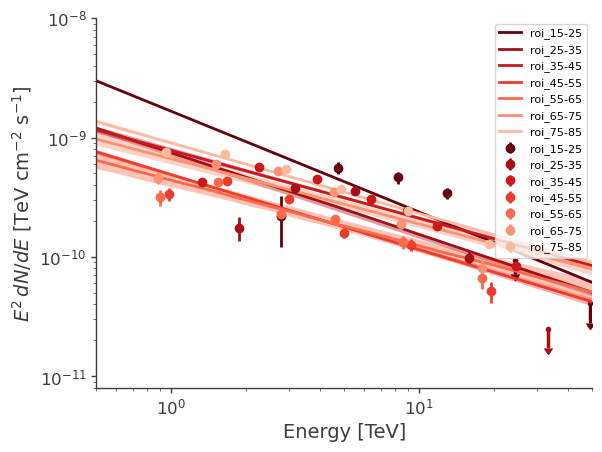

In [50]:
%matplotlib inline
import glob
gc = []
dk = []
dkf = []
de = []
di = []
die = []
den = []
dep = []
dien = []
diep = []
ss = []
ssr= []
x_Max=50.
x_Min=0.5
y_Min=0.8e-11
y_Max=1e-8
fig,ax = plt.subplots()
folder_path = f"/data/home/cwy/Science/3MLWCDA/Standard/res/{region_name}"
subfolders = glob.glob(folder_path + '/**/', recursive=True)
sorted_files = sorted(subfolders[1:], key=lambda x: int(x.split('_')[-1].split('-')[-2]))
# 打印所有找到的子文件夹路径
for i,subfolder in enumerate(sorted_files): #[:7]
    name = subfolder.split("/")[-2]
    print(name)
    specpath = subfolder+"Results.fits"
    resultsss = load_analysis_results(specpath)
    resultdict = resultsss.get_data_frame()
    gc.append(range(20,360,10)[i])
    dk.append(resultdict.loc["Diffuse.spectrum.main.Powerlaw.K"]["value"])
    de.append(resultdict.loc["Diffuse.spectrum.main.Powerlaw.K"]["error"])
    den.append(abs(resultdict.loc["Diffuse.spectrum.main.Powerlaw.K"]["negative_error"]))
    dep.append(abs(resultdict.loc["Diffuse.spectrum.main.Powerlaw.K"]["positive_error"]))
    di.append(resultdict.loc["Diffuse.spectrum.main.Powerlaw.index"]["value"])
    die.append(resultdict.loc["Diffuse.spectrum.main.Powerlaw.index"]["error"])
    dien.append(abs(resultdict.loc["Diffuse.spectrum.main.Powerlaw.index"]["negative_error"]))
    diep.append(abs(resultdict.loc["Diffuse.spectrum.main.Powerlaw.index"]["positive_error"]))
    try:
        dkf.append(resultsall[i][2][0])
    except:
        resultfile = np.load(f"../res/Diffuse_WCDA_case10/resultsall.npy")
        dkf = resultfile[9]
    if i < 7:
        # try:
        plot_spectra(
            resultsss,
            sources_to_use=["Diffuse"],
            include_extended=True,
            ene_min=x_Min,
            ene_max=x_Max,
            num_ene=30,
            energy_unit="TeV",
            flux_unit=f"TeV/(s cm2)", #*
            subplot=ax,
            plot_style_kwargs={"label":name, "color":my.red_palette[-(i+1)], "scale":1/dkf[i]} #
            )
        try:
            data = my.Draw_spectrum_fromfile(subfolder+"Spectrum_Diffuse.txt", label=name, color=my.red_palette[-(i+1)], subplot=ax, scale=1/dkf[i])
            my.spec2naima(f"./spec_{name}.txt", data)
        except:
            pass
        # except Exception as e:
        #     print(f"Error: {e}")
        #     continue
results=[gc,dk,de,den,dep,di,die,dien,diep, dkf]
np.save(f"../res/{region_name}/resultsall.npy",results)
from threeML.analysis_results import AnalysisResultsSet
resultsall
rrr = [it[0][0].results for it in resultsall]
analysis_set = AnalysisResultsSet(rrr)

ax.set_xlim(x_Min,x_Max)
ax.set_ylim(y_Min,y_Max)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(r"$E^2\,dN/dE$ [TeV cm$^{-2}$ s$^{-1}$]")
ax.set_xlabel("Energy [TeV]")
ax.legend()
plt.savefig(f"../res/{region_name}/spectrum_band10-70.png",dpi=300)
plt.savefig(f"../res/{region_name}/spectrum_band10-70.pdf",dpi=300)

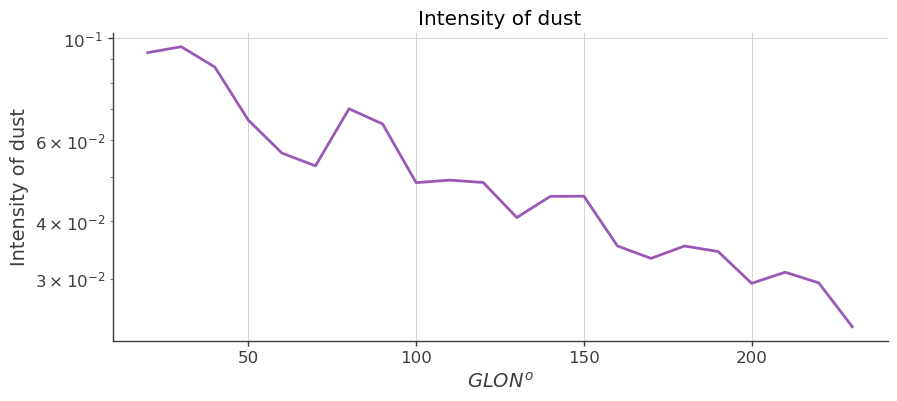

In [44]:
plt.figure(figsize=(10,4)) #
plt.plot(gc, np.array(dkf)) #np.array(den)*1e9, np.array(dep)*1e9 , fmt="o"
plt.yscale("log")
plt.title("Intensity of dust")

plt.ylabel(r"Intensity of dust")
# plt.ylim(1e-7, 1e-4)
plt.grid()
plt.xlabel(r"$GLON^{o}$")
plt.savefig(f"../res/{region_name}/dust.png",dpi=300)
plt.savefig(f"../res/{region_name}/dust.pdf",dpi=300)

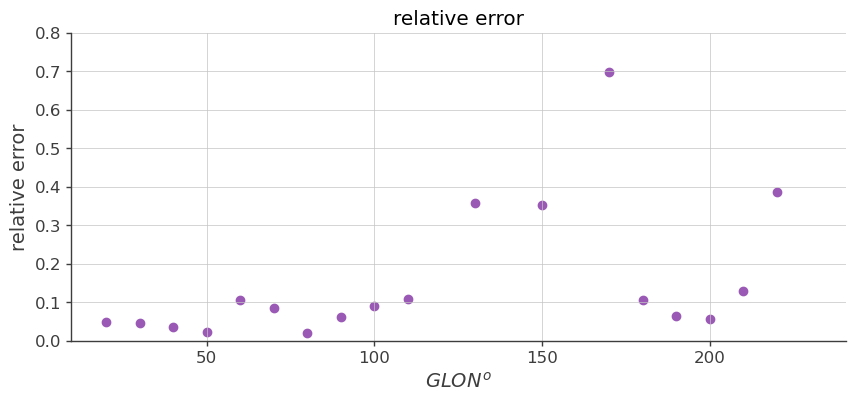

In [54]:
plt.figure(figsize=(10,4)) #
plt.scatter(gc, (np.array(de)*1e9)/(np.array(dk)*1e9), marker="o") #np.array(den)*1e9, np.array(dep)*1e9
# plt.yscale("log")
plt.title("relative error")
plt.ylim(0, 0.8)
plt.ylabel("relative error")
plt.grid()
plt.xlabel(r"$GLON^{o}$")
plt.savefig(f"../res/{region_name}/flux.png",dpi=300)
plt.savefig(f"../res/{region_name}/flux.pdf",dpi=300)

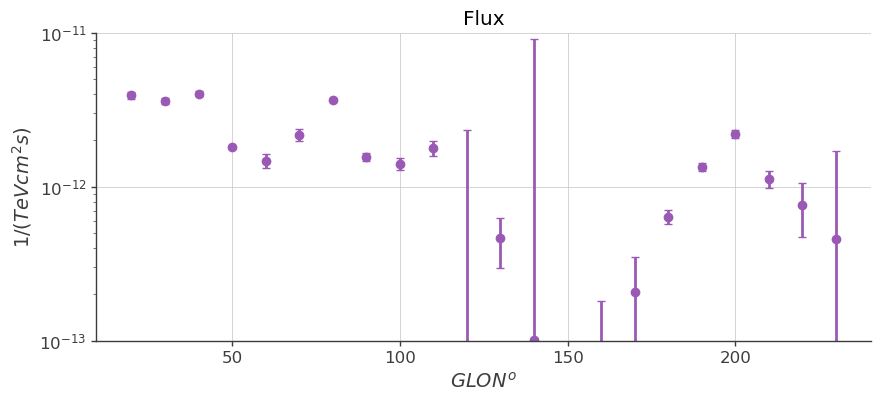

In [52]:
plt.figure(figsize=(10,4)) #
plt.errorbar(gc, np.array(dk)*1e9, [np.array(de)*1e9, np.array(de)*1e9], fmt="o", capsize=3) #np.array(den)*1e9, np.array(dep)*1e9
plt.yscale("log")
plt.title("Flux")
plt.ylim(1e-13, 1e-11)
plt.ylabel(r"$1/(TeV cm^{2} s)$")
plt.grid()
plt.xlabel(r"$GLON^{o}$")
plt.savefig(f"../res/{region_name}/flux.png",dpi=300)
plt.savefig(f"../res/{region_name}/flux.pdf",dpi=300)

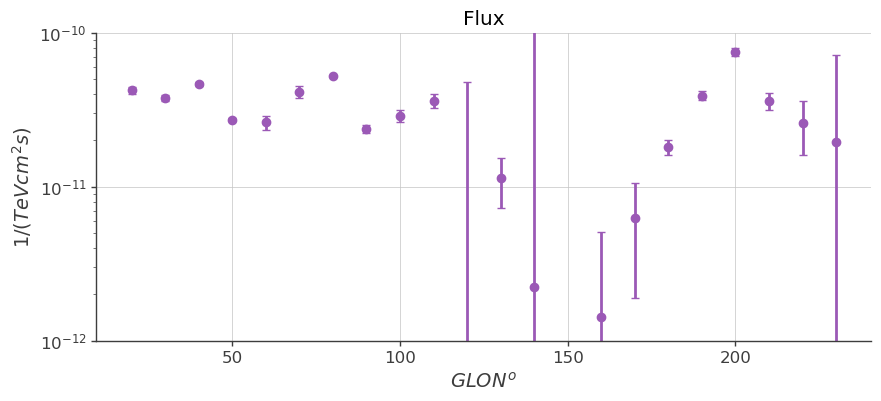

In [53]:
plt.figure(figsize=(10,4)) #
plt.errorbar(gc, np.array(dk)*1e9/np.array(dkf), [np.array(de)*1e9/np.array(dkf), np.array(de)*1e9/np.array(dkf)], fmt="o", capsize=3) #np.array(den)*1e9, np.array(dep)*1e9
plt.yscale("log")
plt.title("Flux")
plt.ylim(1e-12, 1e-10)
plt.ylabel(r"$1/(TeV cm^{2} s)$")
plt.grid()
plt.xlabel(r"$GLON^{o}$")
plt.savefig(f"../res/{region_name}/flux_fullsky.png",dpi=300)
plt.savefig(f"../res/{region_name}/flux_fullsky.pdf",dpi=300)

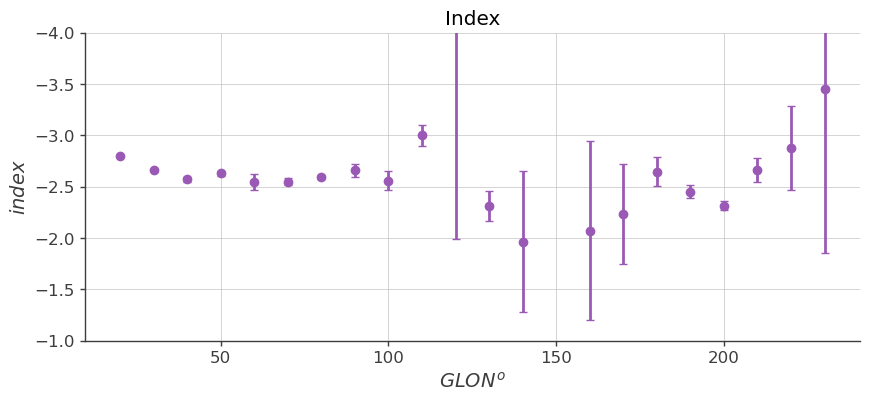

In [51]:
plt.figure(figsize=(10,4)) #
plt.errorbar(gc, di, [die, die], fmt="o", capsize=3) #dien, diep
plt.ylim(-1,-4)
plt.title("Index")
plt.ylabel(r"$index$")
plt.xlabel(r"$GLON^{o}$")
plt.grid()
plt.savefig(f"../res/{region_name}/index.png",dpi=300)
plt.savefig(f"../res/{region_name}/index.pdf",dpi=300)

In [ ]:
%matplotlib inline
import glob
x_Max=50.
x_Min=0.5
y_Min=0.8e-11
y_Max=1e-8
fig,ax = plt.subplots()
folder_path = f"/data/home/cwy/Science/3MLWCDA/Standard/res/{region_name}"
subfolders = glob.glob(folder_path + '/**/', recursive=True)
sorted_files = sorted(subfolders[1:], key=lambda x: int(x.split('_')[-1].split('-')[-2]))
# 打印所有找到的子文件夹路径
for i,subfolder in enumerate(sorted_files[6:14]):
    name = subfolder.split("/")[-2]
    print(name)
    specpath = subfolder+"Results.fits"
    resultsss = load_analysis_results(specpath)
    # try:
    plot_spectra(
        resultsss,
        sources_to_use=["Diffuse"],
        include_extended=True,
        ene_min=x_Min,
        ene_max=x_Max,
        num_ene=30,
        energy_unit="TeV",
        flux_unit=f"TeV/(s cm2)", #*
        subplot=ax,
        plot_style_kwargs={"label":name, "color":my.red_palette[-(i+1)], "scale":1/dkf[i+6]} #
        )
    # except Exception as e:
    #     print(f"Error: {e}")
    #     continue
    

ax.set_xlim(x_Min,x_Max)
ax.set_ylim(y_Min,y_Max)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(r"$E^2\,dN/dE$ [TeV cm$^{-2}$ s$^{-1}$]")
ax.set_xlabel("Energy [TeV]")
ax.legend()
plt.savefig(f"../res/{region_name}/spectrum_band70-150.png",dpi=300)
plt.savefig(f"../res/{region_name}/spectrum_band70-150.pdf",dpi=300)